In [1]:
import pickle
import numpy as np

# Previous version: 2023
# with open("./results/params_search_ppo.pickle", 'rb') as f:
#     result = pickle.load(f)
    
# Current version: 2024
with open("./results/params_search_PPO_solid.pkl", 'rb') as f:
    result = pickle.load(f)
    
tau = [comp['tau'] for comp in result['state']]
b_limit = result['beta_limit']
q_limit = result['q_limit']
n_limit = result['n_limit']
f_limit = result['f_limit']
i_limit = result['i_limit']
tbr = np.array([result['state'][idx]['TBR'] for idx in range(len(tau))])
T = np.array([result['control'][idx]['T_avg'] for idx in range(len(tau))])

tau = np.array(tau)
b_limit = np.array(b_limit)
q_limit = np.array(q_limit)
n_limit = np.array(n_limit)
f_limit = np.array(f_limit)
i_limit = np.array(i_limit)

# 2023 version
indices = np.where(((b_limit == 1) * (n_limit == 1) * (q_limit == 1) * (f_limit == 1) * (tbr >= 1)) == 1)
print("indices : ", indices[0])

indices :  [5539 6075 6755 6914 7003 7590 7896 7935 8081 8091 8115 8583 8642 8647
 8912 9010 9182 9453 9586 9690 9728]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


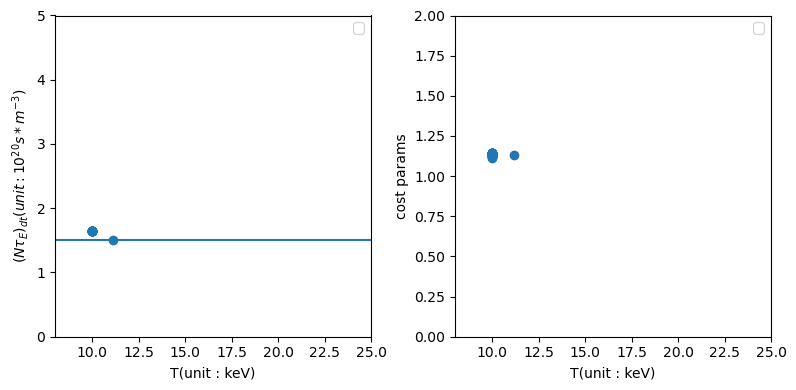

In [2]:
# n*tau*T graph
from src.lawson import Lawson
import matplotlib.pyplot as plt

lawson = Lawson()

# Lawson-criteria
T = np.array([result['control'][idx]['T_avg'] for idx in indices[0]])
n_tau = np.array([result['state'][idx]['n_tau'] for idx in indices[0]])
n_tau_T = T * n_tau

# Cost paramter
cost = np.array([result['state'][idx]['cost'] for idx in indices[0]])

fig, axes = plt.subplots(1,2,figsize = (8,4))
axes = axes.ravel()
ax = axes[0]
ax.scatter(T, n_tau)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("$(N\\tau_E)_{dt}(unit:10^{20}s * m^{-3})$")
ax.axhline(1.5, 0, 1)
ax.set_xlim([8,25])
ax.set_ylim([0,5])
ax.legend()

ax = axes[1]
ax.scatter(T, cost)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("cost params")
ax.set_xlim([8,25])
ax.set_ylim([0,2])
ax.legend()

fig.tight_layout()

In [3]:
arg_min = np.argmin(cost)
arg_min = indices[0][arg_min]

for key in result['state'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['state'][arg_min][key]))
    
for key in result['control'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['control'][arg_min][key]))
    

R : 3.854
a : 0.856
blanket_thickness : 1.192
coil_thickness : 1.257
n : 2.297
TBR : 3.643
beta : 4.377
tau : 0.714
Ip : 7.544
q : 2.069
f_BS : 0.789
Q_parallel : 362.659
n_g : 3.275
q_kink : 2.000
beta_troyon : 4.952
f_NC : 0.818
n_tau : 1.639
n_tau_lower : 3.605
cost : 1.116
betan : 4.000
k : 1.900
epsilon : 4.500
electric_power : 502760009.766
T_avg : 10.000
B0 : 15.188
H : 1.300
armour_thickness : 0.010
RF_recirculating_rate : 0.200


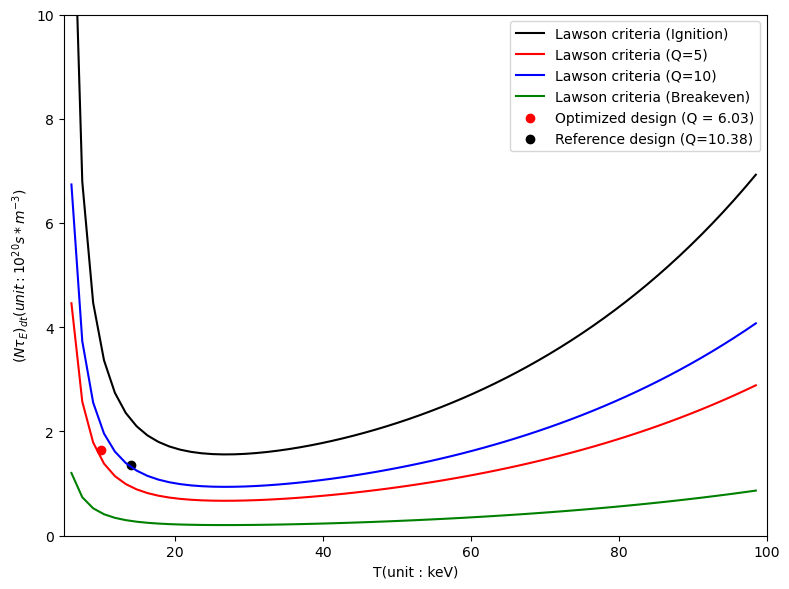

In [7]:
# Lawson curve
tau_operation = result['state'][arg_min]['tau']
T_operation = result['control'][arg_min]['T_avg']
Q_operation = 6.03

# Reference case
Q_reference = 10.38
n_reference = 1.43
tau_reference = 0.944
T_reference = 14

n_tau = result['state'][arg_min]['n_tau']
n_tau_T = T * n_tau

T = np.linspace(6, 100, 64, endpoint=False)
n = result['state'][arg_min]['n'] * 10 ** 20
B = result['control'][arg_min]['B0'] * (1 - (result['state'][arg_min]['a'] + result['state'][arg_min]['blanket_thickness'])/result['state'][arg_min]['R'])

psi = 10 ** (-3)

Q = 10

n_tau = [lawson.compute_n_tau_lower_bound(t, n, B, psi) * 10 ** (-20) for t in T]
n_tau_5 = [lawson.compute_n_tau_Q_lower_bound(t, n, B, psi, 5) * 10 ** (-20) for t in T]
n_tau_Q = [lawson.compute_n_tau_Q_lower_bound(t, n, B, psi, Q) * 10 ** (-20) for t in T]
n_tau_break = [lawson.compute_n_tau_Q_lower_bound(t, n, B, psi, 1) * 10 ** (-20) for t in T]
n *= 10 ** (-20)
        
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(T, n_tau, "k", label = "Lawson criteria (Ignition)")
ax.plot(T, n_tau_5, "r", label = "Lawson criteria (Q=5)")
ax.plot(T, n_tau_Q, "b", label = "Lawson criteria (Q={})".format(Q))
ax.plot(T, n_tau_break, "g", label = "Lawson criteria (Breakeven)")
ax.scatter(T_operation, tau_operation * n, c = 'r', label = 'Optimized design (Q = {:.2f})'.format(Q_operation))
ax.scatter(T_reference, tau_reference * n_reference, c = 'k', label = 'Reference design (Q={:.2f})'.format(Q_reference))

ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("$(N\\tau_E)_{dt}(unit:10^{20}s * m^{-3})$")
ax.set_xlim([5,100])
ax.set_ylim([0,10])
ax.legend()
fig.tight_layout()

plt.savefig("./results/lawson_comparison.png")

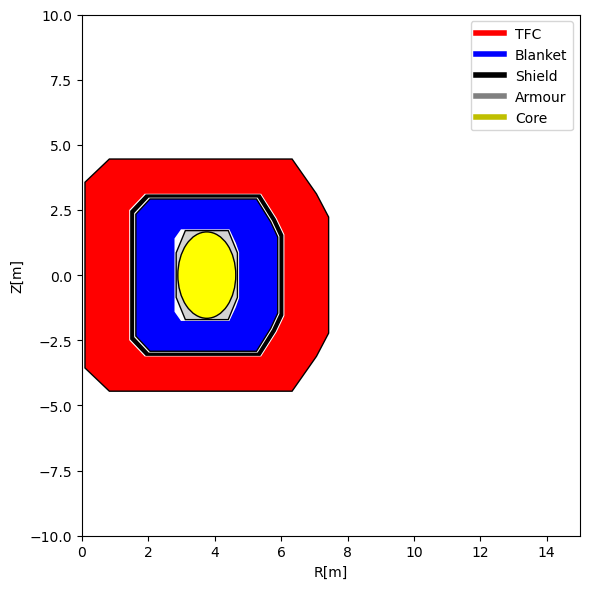

In [23]:
from src.plot import plot_design_poloidal

fig, ax = plot_design_poloidal(
    result['state'][arg_min]['R'],
    result['state'][arg_min]['a'],
    result['state'][arg_min]['a'] * result['control'][arg_min]['k'],
    result['control'][arg_min]['armour_thickness'],
    result['state'][arg_min]['blanket_thickness'],
    result['state'][arg_min]['coil_thickness'],
    0.1,
    0,
    15,
    -10,
    +10
)

fig.tight_layout()

### Gridsearch case

In [1]:
import pickle
import numpy as np

with open("./results/params_search_gridsearch_solid.pkl", 'rb') as f:
    result = pickle.load(f)
    
tau = [comp['tau'] for comp in result['state']]
b_limit = result['beta_limit']
q_limit = result['q_limit']
n_limit = result['n_limit']
f_limit = result['f_limit']
i_limit = result['i_limit']
tbr = np.array([result['state'][idx]['TBR'] for idx in range(len(tau))])
T = np.array([result['control'][idx]['T_avg'] for idx in range(len(tau))])

tau = np.array(tau)
b_limit = np.array(b_limit)
q_limit = np.array(q_limit)
n_limit = np.array(n_limit)
f_limit = np.array(f_limit)
i_limit = np.array(i_limit)

indices = np.where(((b_limit == 1) * (q_limit == 1) * (n_limit == 1) * (f_limit == 1) * (tbr >= 1) * (tbr < 2)) == 1)
print("indices : ", indices[0])
print("# of cases : {}".format(len(indices[0])))

indices :  [  31   32   34 ... 9968 9969 9970]
# of cases : 1220


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


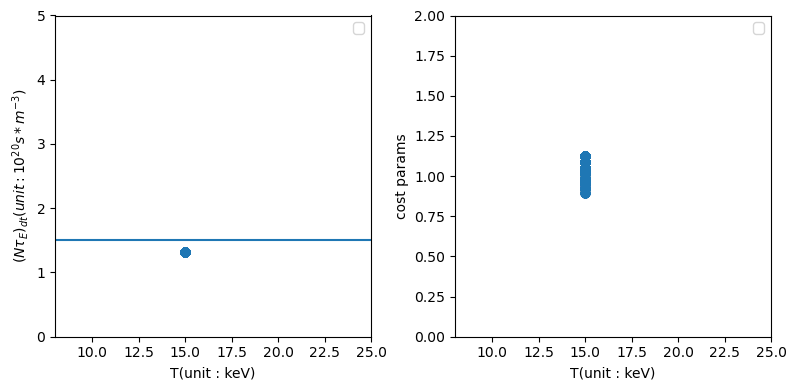

In [2]:
# n*tau*T graph
from src.lawson import Lawson
import matplotlib.pyplot as plt

lawson = Lawson()

# Lawson-criteria
T = np.array([result['control'][idx]['T_avg'] for idx in indices[0]])
n_tau = np.array([result['state'][idx]['n_tau'] for idx in indices[0]])
n_tau_T = T * n_tau

# Cost paramter
cost = np.array([result['state'][idx]['cost'] for idx in indices[0]])

fig, axes = plt.subplots(1,2,figsize = (8,4))
axes = axes.ravel()
ax = axes[0]
ax.scatter(T, n_tau)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("$(N\\tau_E)_{dt}(unit:10^{20}s * m^{-3})$")
ax.axhline(1.5, 0, 1)
ax.set_xlim([8,25])
ax.set_ylim([0,5])
ax.legend()

ax = axes[1]
ax.scatter(T, cost)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("cost params")
ax.set_xlim([8,25])
ax.set_ylim([0,2])
ax.legend()

fig.tight_layout()

In [3]:
arg_min = np.argmin(cost)
arg_min = indices[0][arg_min]

for key in result['state'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['state'][arg_min][key]))
    
for key in result['control'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['control'][arg_min][key]))
    

R : 6.550
a : 1.531
blanket_thickness : 1.164
coil_thickness : 0.775
n : 1.261
TBR : 1.822
beta : 4.103
tau : 1.046
Ip : 12.598
q : 2.105
f_BS : 0.503
Q_parallel : 596.636
n_g : 1.711
q_kink : 2.000
beta_troyon : 4.112
f_NC : 0.769
n_tau : 1.319
n_tau_lower : 2.082
cost : 0.892
betan : 3.333
k : 1.856
epsilon : 4.278
electric_power : 1500000000.000
T_avg : 15.000
B0 : 11.333
H : 1.133
armour_thickness : 0.050
RF_recirculating_rate : 0.189


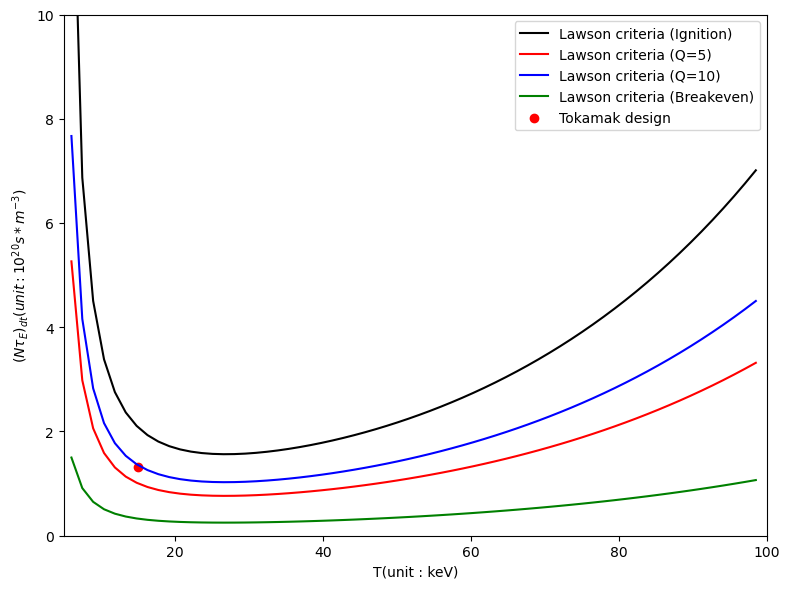

In [4]:
# Lawson curve
tau_operation = result['state'][arg_min]['tau']
T_operation = result['control'][arg_min]['T_avg']

n_tau = result['state'][arg_min]['n_tau']
n_tau_T = T * n_tau

T = np.linspace(6, 100, 64, endpoint=False)
n = result['state'][arg_min]['n'] * 10 ** 20
B = result['control'][arg_min]['B0'] * (1 - (result['state'][arg_min]['a'] + result['state'][arg_min]['blanket_thickness'])/result['state'][arg_min]['R'])

psi = 10 ** (-3)

Q = 10

n_tau = [lawson.compute_n_tau_lower_bound(t, n, B, psi) * 10 ** (-20) for t in T]
n_tau_5 = [lawson.compute_n_tau_Q_lower_bound(t, n, B, psi, 5) * 10 ** (-20) for t in T]
n_tau_Q = [lawson.compute_n_tau_Q_lower_bound(t, n, B, psi, Q) * 10 ** (-20) for t in T]
n_tau_break = [lawson.compute_n_tau_Q_lower_bound(t, n, B, psi, 1) * 10 ** (-20) for t in T]
n *= 10 ** (-20)
        
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(T, n_tau, "k", label = "Lawson criteria (Ignition)")
ax.plot(T, n_tau_5, "r", label = "Lawson criteria (Q=5)")
ax.plot(T, n_tau_Q, "b", label = "Lawson criteria (Q={})".format(Q))
ax.plot(T, n_tau_break, "g", label = "Lawson criteria (Breakeven)")
ax.scatter(T_operation, tau_operation * n, c = 'r', label = 'Tokamak design')

ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("$(N\\tau_E)_{dt}(unit:10^{20}s * m^{-3})$")
ax.set_xlim([5,100])
ax.set_ylim([0,10])
ax.legend()
fig.tight_layout()

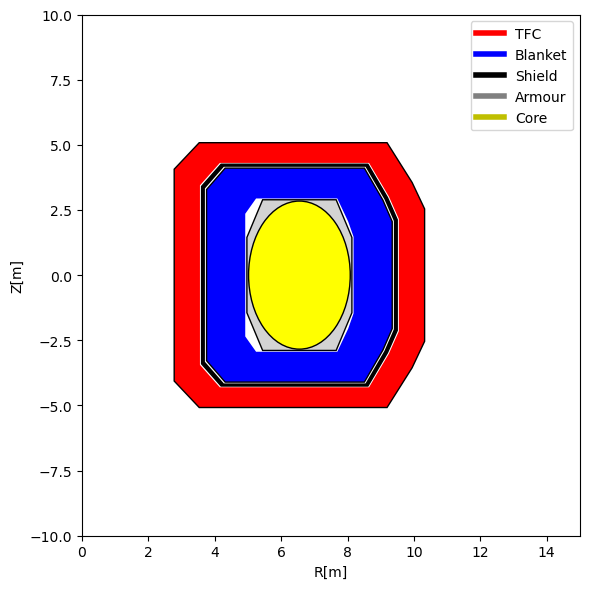

In [18]:
from src.plot import plot_design_poloidal

fig, ax = plot_design_poloidal(
    result['state'][arg_min]['R'],
    result['state'][arg_min]['a'],
    result['state'][arg_min]['a'] * result['control'][arg_min]['k'],
    result['control'][arg_min]['armour_thickness'],
    result['state'][arg_min]['blanket_thickness'],
    result['state'][arg_min]['coil_thickness'],
    0.1,
    0,
    15,
    -10,
    +10
)

fig.tight_layout()

### Reward shape engineering

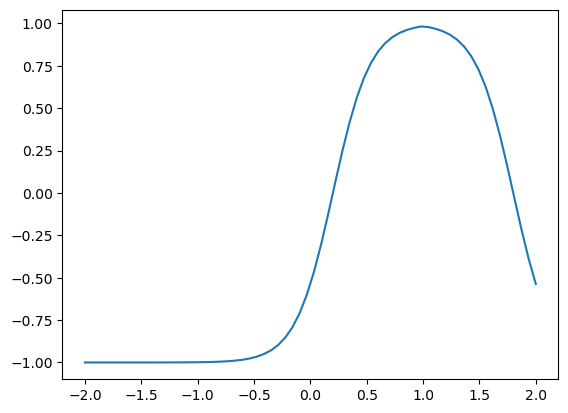

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

def compute_sigmoid(x):
    return math.tanh(x)

def reward_func(x, scale, a, x_min, x_max):
    xn = x / scale
    xnl = x_min / scale
    xrl = x_max / scale
    
    if xn < xrl:
        reward = compute_sigmoid(a * (xn - xnl))
    else:
        reward = compute_sigmoid(a * (2 * xrl - xnl - xn))
        
    return reward

x = np.linspace(-2,2,64)
y = np.array([reward_func(t, 1, 3, 0.2, 1.0) for t in x])

plt.plot(x,y)

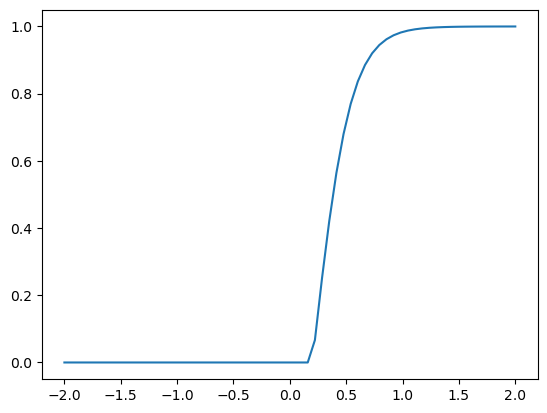

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

def compute_sigmoid(x):
    return math.tanh(x)

def reward_func(x, scale, a, x_min, x_max):
    xn = x / scale
    xnl = x_min / scale
    xrl = x_max / scale
    
    if xn > xnl:
        reward = compute_sigmoid(a * (xn - xnl))
    else:
        reward = 0
        
    return reward

x = np.linspace(-2,2,64)
y = np.array([reward_func(t, 1, 3, 0.2, 1.0) for t in x])

plt.plot(x,y)

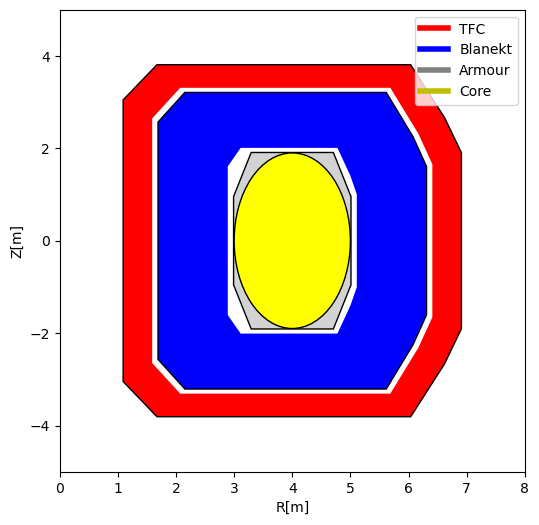

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.pyplot import Axes
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np

def draw_core(ax:Axes, R : float, a : float, b : float):
    ax.add_patch(
        patches.Ellipse(
            xy = (R, 0), # xy xy coordinates of ellipse centre.
            width = 2 * a,   # width Total length (diameter) of horizontal axis.
            height = 2 * b, # height Total length (diameter) of vertical axis.
            angle = 0, # angle Rotation in degrees anti-clockwise. 0 by default
            edgecolor = 'black',
            linestyle = 'solid', 
            fill = True,
            facecolor = 'yellow',
            )
    )
    
    return ax

def draw_armour(ax:Axes, R : float, a : float, b : float):
    
    ax.add_patch(
        patches.Polygon(
            np.array([
                [R-a, -0.5*b],
                [R-0.7*a, -b], 
                [R+0.7*a, -b], 
                [R+a, -0.5 * b], 
                [R+a, 0.5*b], 
                [R+0.7*a, b], 
                [R-0.7*a, b],
                [R-a, 0.5*b]
                ]), # xy
            closed=True,
            edgecolor = 'black',
            linestyle = 'solid', 
            fill = True,
            facecolor = 'lightgray',
        )
    )    
    
    return ax

def draw_blanket(ax:Axes, R : float, a_inner : float, b_inner : float, a_outer : float, b_outer : float):
    ax.add_patch(
        patches.Polygon(
            np.array([
                [R-a_outer*1.0, -b_outer * 0.8], 
                [R-a_outer*0.8, -b_outer * 1.0], 
                [R+a_outer*0.7, -b_outer * 1.0], 
                [R+a_outer*0.9, -b_outer * 0.7], 
                [R+a_outer*1.0, -b_outer * 0.5], 
                [R+a_outer*1.0, b_outer * 0.5], 
                [R+a_outer*0.9, b_outer * 0.7], 
                [R+a_outer*0.7, b_outer * 1.0], 
                [R-a_outer*0.8, b_outer * 1.0], 
                [R-a_outer*1.0, b_outer * 0.8]
            ]),
            closed=True,
            edgecolor = 'black',
            linestyle = 'solid', 
            fill = True,
            facecolor = 'blue',
        )
    )    
    
    ax.add_patch(
        patches.Polygon(
            np.array([
                [R-a_inner*1.0, -b_inner * 0.8], 
                [R-a_inner*0.8, -b_inner * 1.0], 
                [R+a_inner*0.7, -b_inner * 1.0], 
                [R+a_inner*0.9, -b_inner * 0.7], 
                [R+a_inner*1.0, -b_inner * 0.5], 
                [R+a_inner*1.0, b_inner * 0.5], 
                [R+a_inner*0.9, b_inner * 0.7], 
                [R+a_inner*0.7, b_inner * 1.0], 
                [R-a_inner*0.8, b_inner * 1.0], 
                [R-a_inner*1.0, b_inner * 0.8]
                ]),
            closed=True,
            edgecolor = 'none',
            linestyle = 'solid', 
            fill = True,
            facecolor = 'white',
        )
    )    
    
    return ax

def draw_coil(ax:Axes,R : float, a_inner : float, b_inner : float, a_outer : float, b_outer : float):
       
    ax.add_patch(
        patches.Polygon(
            np.array([
                [R-a_outer*1.0, -b_outer * 0.8], 
                [R-a_outer*0.8, -b_outer * 1.0], 
                [R+a_outer*0.7, -b_outer * 1.0], 
                [R+a_outer*0.9, -b_outer * 0.7], 
                [R+a_outer*1.0, -b_outer * 0.5], 
                [R+a_outer*1.0, b_outer * 0.5], 
                [R+a_outer*0.9, b_outer * 0.7], 
                [R+a_outer*0.7, b_outer * 1.0], 
                [R-a_outer*0.8, b_outer * 1.0], 
                [R-a_outer*1.0, b_outer * 0.8]
            ]),
            closed=True,
            edgecolor = 'black',
            linestyle = 'solid', 
            fill = True,
            facecolor = 'red',
        )
    )    
    
    ax.add_patch(
        patches.Polygon(
            np.array([
                [R-a_inner*1.0, -b_inner * 0.8], 
                [R-a_inner*0.8, -b_inner * 1.0], 
                [R+a_inner*0.7, -b_inner * 1.0], 
                [R+a_inner*0.9, -b_inner * 0.7], 
                [R+a_inner*1.0, -b_inner * 0.5], 
                [R+a_inner*1.0, b_inner * 0.5], 
                [R+a_inner*0.9, b_inner * 0.7], 
                [R+a_inner*0.7, b_inner * 1.0], 
                [R-a_inner*0.8, b_inner * 1.0], 
                [R-a_inner*1.0, b_inner * 0.8]
                ]),
            closed=True,
            edgecolor = 'none',
            linestyle = 'solid', 
            fill = True,
            facecolor = 'white',
        )
    )    
    
    return ax

def plot_design_poloidal(
    R:float,
    a:float,
    b:float,
    d_armour:float,
    d_blanket:float,
    d_coil:float,
    x_min:float = 0,
    x_max:float = 10,
    y_min:float = -8,
    y_max:float = 8,
    ):
    
    a_armour = a + d_armour
    b_armour = b + d_armour

    a_blanket = a_armour + 0.1
    b_blanket = b_armour + 0.1

    a_coil = a_blanket + d_blanket + 0.1
    b_coil = b_blanket + d_blanket + 0.1

    fig = plt.figure(figsize = (6, 6))
    ax = fig.add_subplot()

    ax = draw_coil(ax, R, a_coil, b_coil, a_coil + d_coil, b_coil + d_coil)
    ax = draw_blanket(ax, R, a_blanket, b_blanket, a_blanket + d_blanket, b_blanket + d_blanket)
    ax = draw_armour(ax, R, a_armour, b_armour)
    ax = draw_core(ax, R, a, b)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_xlabel('R[m]')
    ax.set_ylabel('Z[m]')
    
    legend_elements = [
        Line2D([0],[0], color = 'r', lw = 4, label = "TFC"),
        Line2D([0],[0], color = 'b', lw = 4, label = "Blanekt"),
        Line2D([0],[0], color = 'gray', lw = 4, label = "Armour"),
        Line2D([0],[0], color = 'y', lw = 4, label = "Core"),
        ]
    ax.legend(handles = legend_elements, loc ="upper right")
    return ax
    
k = 1.9
a = 1.0
b = k*a
R = 4.0
d_armour = 0.01
d_blanket = 1.2
d_coil = 0.5

ax = plot_design_poloidal(R,a,b,d_armour,d_blanket, d_coil, 0, 8, -5, 5)

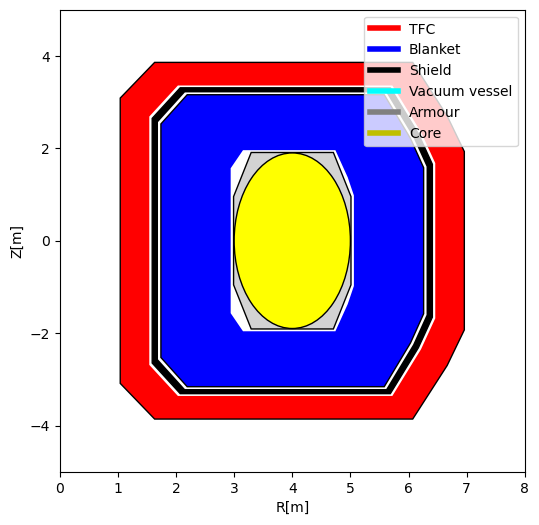

In [ ]:
from src.plot import plot_design_poloidal

k = 1.9
a = 1.0
b = k*a
R = 4.0
d_armour = 0.01
d_blanket = 1.2
d_coil = 0.5
d_shield = 0.1

ax = plot_design_poloidal(
    R,a,b,d_armour,d_blanket, d_coil, d_shield, 0, 8, -5, 5
)